# Interacting with PubMedCLIP

Load the pretrained PubMedCLIP model and experiment with using it.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-__fowk5_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-__fowk5_
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.0.0+cu118


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the model

Load the pretrained model.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import clip
pubmedclip_model, pre = clip.load("ViT-B/32", jit=False)

In [6]:
checkpoint = torch.load("/content/drive/MyDrive/Master Thesis/Models/PubMedCLIP_ViT32 (1).pth")
pubmedclip_model.load_state_dict(checkpoint['state_dict'])
pubmedclip_model = pubmedclip_model.float()

In [7]:
pubmedclip_model.cuda().eval()
input_resolution = pubmedclip_model.visual.input_resolution
context_length = pubmedclip_model.context_length
vocab_size = pubmedclip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in pubmedclip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

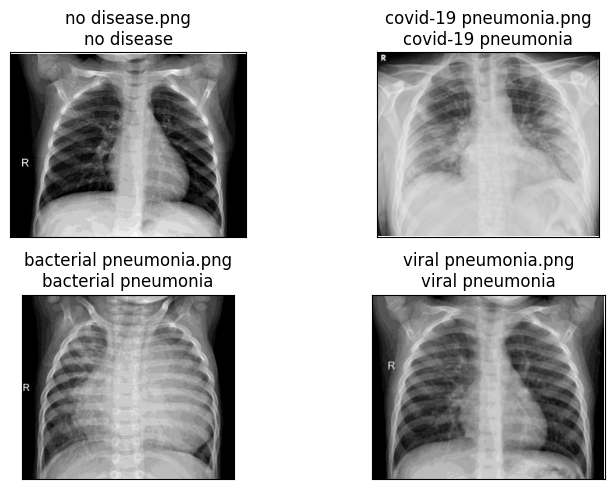

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

original_images = []
images = []
texts = []
plt.figure(figsize=(8, 5))

image_dir = "/content/drive/MyDrive/Master Thesis/Models"

for filename in [filename for filename in os.listdir(image_dir) if filename.endswith(".png")]:
    name = os.path.splitext(filename)[0]
    name = name.split("-x-ray")[0]
    
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
  
    plt.subplot(2, 2, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{name}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(pre(image))
    texts.append(name)

plt.tight_layout()

In [12]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["A chest X-ray from a person who has " + desc for desc in texts]).cuda()

## Calculating cosine similarity for PubMedCLIP

We normalize the features and calculate the dot product of each pair.

In [13]:
with torch.no_grad():
    image_features = pubmedclip_model.encode_image(image_input).float()
    text_features = pubmedclip_model.encode_text(text_tokens).float()

In [14]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

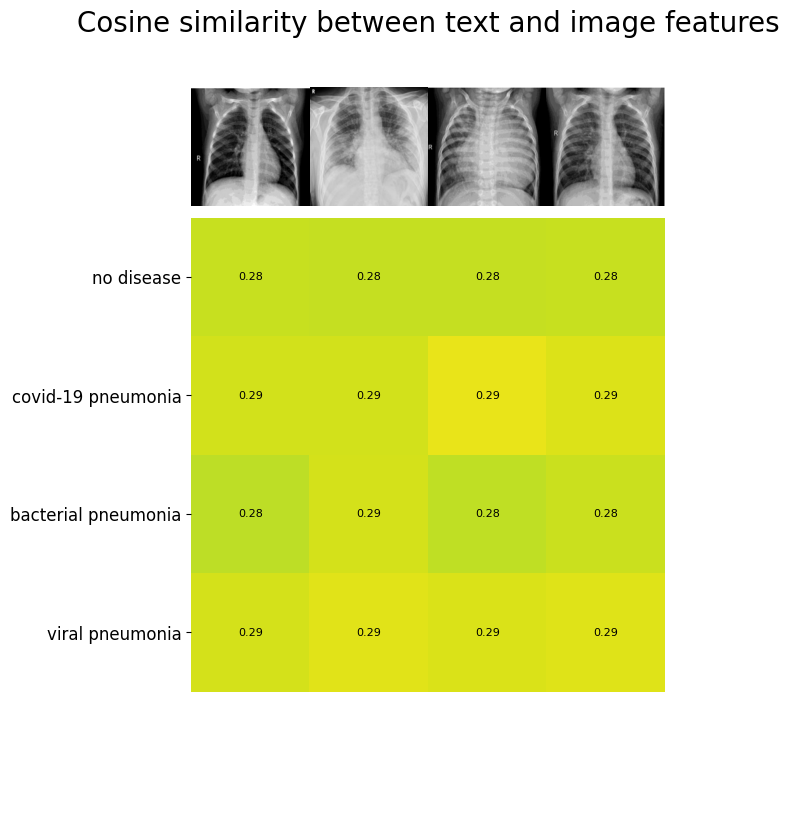

In [15]:
count = len(texts)

plt.figure(figsize=(14, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=8)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

For standard CLIP

In [16]:
clip_model, pre = clip.load("ViT-B/32", jit=False)

In [17]:
with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()
    text_features = clip_model.encode_text(text_tokens).float()

In [18]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

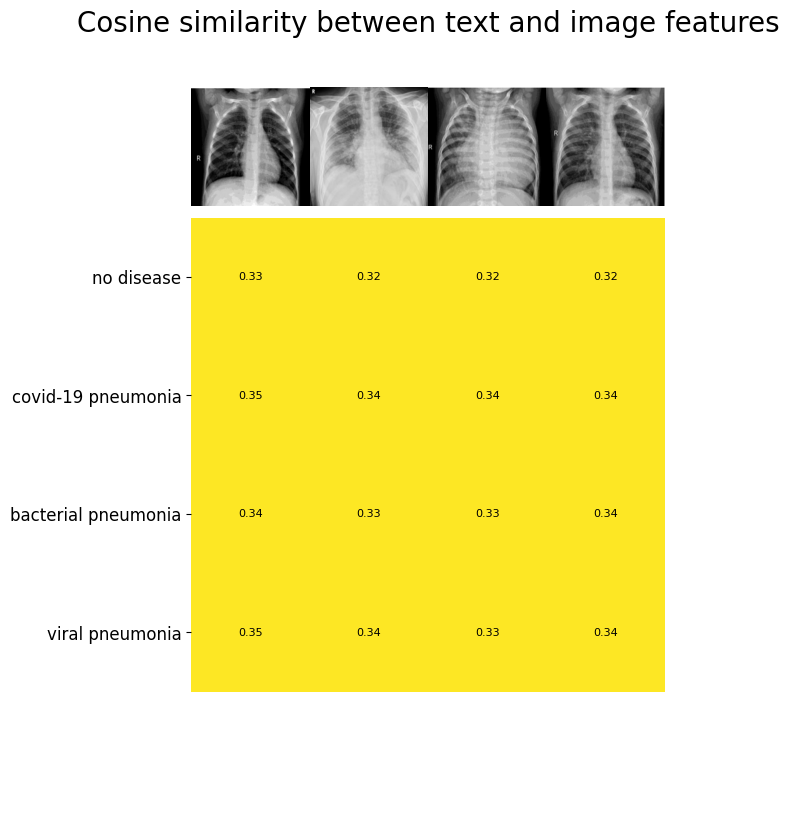

In [19]:
count = len(texts)

plt.figure(figsize=(14, 10))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=8)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)